# Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Dataset

In [2]:
df_data = pd.read_csv('titanic.csv')
df_data

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,NaN,Southampton,no,True
887,female,19.0,0,30.0000,First,B,Southampton,yes,True
888,female,NaN,2,23.4500,Third,NaN,Southampton,no,False
889,male,26.0,0,30.0000,First,C,Cherbourg,yes,True


# Data Analysis (EDA)

In [3]:
numerical = ['age', 'parch', 'fare','alone']
categorical = ['sex', 'class', 'deck', 'embark_town']

In [4]:
df_data['is_alive'] = np.where(df_data['alive'] == 'yes', 1, 0) 

## Check Correlation between alive and numerical data

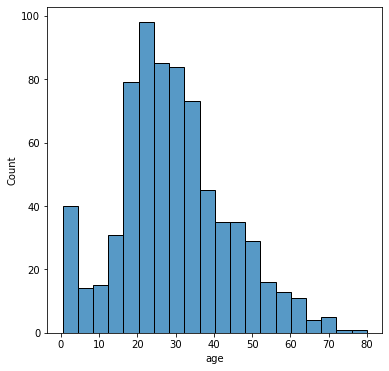

In [5]:
plt.figure(figsize=(6,6))
sns.histplot(data=df_data['age'])
plt.show()

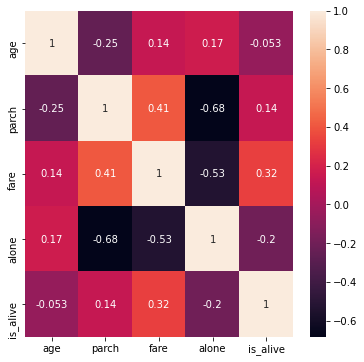

In [6]:
plt.figure(figsize=(6,6))
sns.heatmap(data = df_data.corr(method='spearman'), annot = True)
plt.show()

nilai korelasi antara alive dengan age, parch dan alone berada dibawah 0.3 yang berarti nilai korelasinya rendah, maka fitur tersebut tidak akan digunakan dalam model 

In [7]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['fare'])
plt.show()


NameError: name 'df' is not defined

<Figure size 864x432 with 0 Axes>

Feature `fare` memiliki banyak outlier

## Check Correlation between alive and categorical data

In [ ]:
for i in categorical:
    df_count = pd.crosstab(df_data[i], df_data['alive'])
    stats, pval, dof, expected = chi2_contingency(df_count)
    if pval <= 0.05:
        print(f'Ada keterkaitan antara {i} dan alive')
    else:
        print(f'Tidak Ada keterkaitan antara {i} dan alive')


## Check Missing Values

Berdasarkan 2 point diatas, maka fitur yang akan digunakan adalah : fare, sex, class, dan embark_town

In [ ]:
df = df_data[['is_alive', 'sex', 'class', 'embark_town', 'fare']]

In [ ]:
df.head()

In [ ]:
df.isna().sum()

In [ ]:
df['embark_town'].fillna(value=df['embark_town'].mode().item(), inplace=True)

In [ ]:
df.isna().sum()

# Preprocessing
1. Category Encoders Library: class (Ordinal Data)
2. One Hot Encoding : sex, embark_town (Nominal Data)
3. Robust Scaler : fare (Numeric Data yang memiliki banyak outlier)

## Category Encoders Library for Ordinal Data

In [ ]:
df['class'].value_counts()

In [ ]:
ordinal_mapping = [
    {
        'col': 'class',
        'mapping': {None:0, 'First':1, 'Second': 2, 'Third':3}
    }
]

In [ ]:
ordinal_encoder = ce.OrdinalEncoder(mapping=ordinal_mapping)
df['class'] = ordinal_encoder.fit_transform(df['class'])
df.head()

In [ ]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'), ['sex','embark_town']), # name, transformer, kolom
    ('robust',RobustScaler(), ['fare'])
], remainder='passthrough')

In [ ]:
transformer.fit_transform(df)

# Data Splitting

In [ ]:
x = df.drop(columns='is_alive')
y = df['is_alive']

# Data Transform

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=10)

In [ ]:
transformer.transformers_

In [ ]:
transformer.transformers_[0][1].get_feature_names()

In [ ]:
features = list(transformer.transformers_[0][1].get_feature_names()) + ['fare scaled', 'class']
features

In [ ]:
x_train_preprocessed = transformer.fit_transform(x_train)
x_test_preprocessed = transformer.transform(x_test)

In [ ]:
x_train_preprocessed = pd.DataFrame(x_train_preprocessed)
x_test_preprocessed = pd.DataFrame(x_test_preprocessed)

In [ ]:
x_train_preprocessed.columns = features
x_train_preprocessed

In [ ]:
x_test_preprocessed.columns = features
x_test_preprocessed

# Model Fitting & Evaluation

## Logistic Regression

In [ ]:
model=LogisticRegression()
model.fit(x_train_preprocessed, y_train)
modelAccScore = accuracy_score(y_test,model.predict(x_test_preprocessed))

print('model accuracy score in test dataset: ', modelAccScore)

## KNN Classifier

In [ ]:
# Choose Factor K
k = range(1, 100, 2) # nilai k lebih baik kalau ganjil
testing_score = []
training_score = []
score = 0

for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_preprocessed, y_train)
    
    y_predict_test = knn.predict(x_test_preprocessed)
    acc_score = accuracy_score(y_test, y_predict_test)
    testing_score.append(acc_score)
    
    if score < acc_score:
        score = acc_score
        best_k = i

print('best k : ', best_k)
print('model accuracy score in test dataset : ', score)

## Decision Tree

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3) # criterion{“gini”, “entropy”}, default=”gini”
tree.fit(x_train_preprocessed, y_train)
y_predict = tree.predict(x_test_preprocessed)

modelAccScore = accuracy_score(y_test, y_predict)
print('Nilai akurasi model ini: ', modelAccScore)